# Daily Training using API

In [5]:
from datetime import datetime, timedelta, date
import requests
import csv
import xml.etree.ElementTree as ET
import pandas as pd
import mlflow

from darts import TimeSeries
from darts.models import ExponentialSmoothing
from darts.metrics import rmse

### URL Information:  
* my token -  79d02170-206a-4f7d-ac31-01b492203cf4
* how to make url: https://transparency.entsoe.eu/content/static_content/Static%20content/web%20api/Guide.html#_available_parameters
* our parameters
- document type= A44
- processType= A01 day ahead price
- in/out domain = DK1 price
- periodStart= today-30days
- periodEnd = today

In [2]:
# for url, time setting
current_date = datetime.now()
one_day = timedelta(days=1)
one_hour = timedelta(hours=1)

# Get the current date and time
next_day = current_date + one_day - one_hour
before_30 = current_date - timedelta(days=30)

# from current data 
year = next_day.year
month = next_day.month
day = next_day.day

# from before_30
year_30 = before_30.year
month_30 = before_30.month
day_30 = before_30.day


# Format the datetime as "YYYYMMDD0000"
formatted_datetime = next_day.strftime("%Y%m%d0000")
formatted_before30days = before_30.strftime("%Y%m%d0000")

# completed url
url = 'https://web-api.tp.entsoe.eu/api?securityToken=79d02170-206a-4f7d-ac31-01b492203cf4&documentType=A44&processType=A01&in_Domain=10YDK-1--------W&out_Domain=10YDK-1--------W&periodStart=' + formatted_before30days + '&periodEnd=' + formatted_datetime

response = requests.get(url)

if response.status_code == 200:
    content = response.content.decode('utf-8')  # Decode the response content as UTF-8
    csv_reader = csv.reader(content.splitlines(), delimiter=',')
    data = list(csv_reader)
    # Process the data as needed
else:
    print('Error:', response.status_code)
    
# Parse the XML document
tree = ET.fromstring(content)

# Define the XML namespace
namespace = {'ns': 'urn:iec62325.351:tc57wg16:451-3:publicationdocument:7:0'}

# Extract price and date information
time_series_elements = tree.findall('.//ns:TimeSeries', namespace)

# Create an empty list to store price data
price_data = []

for time_series in time_series_elements:
    # Get the mRID of the TimeSeries
    mrid = time_series.find('ns:mRID', namespace).text
    
    # Get the Period elements within the TimeSeries
    period_elements = time_series.findall('.//ns:Period', namespace)
    
    for period in period_elements:
        # Get the start and end dates of the Period
        start_date = period.find('ns:timeInterval/ns:start', namespace).text
        end_date = period.find('ns:timeInterval/ns:end', namespace).text
        
        # Get the Point elements within the Period
        point_elements = period.findall('.//ns:Point', namespace)
        
        for point in point_elements:
            # Get the position and price of each Point
            position = point.find('ns:position', namespace).text
            price = point.find('ns:price.amount', namespace).text
            
            # Append price data to the list
            price_data.append({
                'Price': price
            })

# Create a DataFrame from the price data
df_price = pd.DataFrame(price_data)

In [3]:
# time table setting
current_date = datetime.now()
one_day = timedelta(days=1)
one_hour = timedelta(hours=1)

# Get the current date and time
next_day = current_date + one_day - one_hour
before_30 = current_date - timedelta(days=30)

# from current data 
year = next_day.year
month = next_day.month
day = next_day.day

# from before_30
year_30 = before_30.year
month_30 = before_30.month
day_30 = before_30.day

start_date = datetime(year_30, month_30, day_30)
end_date = datetime(year, month, day)

# Create a list of time values
time_values = []

# Generate time values from start date to end date with an hourly interval
current_date = start_date
while current_date <= end_date:
    time_values.append(current_date)
    current_date += timedelta(hours=1)

# Create a dataframe with time values
df_time = pd.DataFrame({'date': time_values})

# concate two data frame
df_el = pd.concat([df_time, df_price], axis=1)
df_el.dropna(inplace = True)

# dataframe to timeseries
ts = TimeSeries.from_dataframe(df_el, time_col='date', value_cols = 'Price', fill_missing_dates=False, freq='H')

In [14]:
# time table setting
current_date = datetime.now()
one_day = timedelta(days=1)
one_hour = timedelta(hours=1)

# Get the current date and time
next_day = current_date + one_day - one_hour
before_30 = next_day - timedelta(days=30)

# from current data 
year = next_day.year
month = next_day.month
day = next_day.day

# from before_30
year_30 = before_30.year
month_30 = before_30.month
day_30 = before_30.day

start_date = datetime(year_30, month_30, day_30)
end_date = datetime(year, month, day)

# Create a list of time values
time_values = []

# Generate time values from start date to end date with an hourly interval
current_date = start_date
while current_date <= end_date:
    time_values.append(current_date)
    current_date += timedelta(hours=1)

# Create a dataframe with time values
df_time = pd.DataFrame({'date': time_values})

# concate two data frame
df_el = pd.concat([df_time, df_price], axis=1)
df_el.dropna(inplace = True)

# dataframe to timeseries
ts = TimeSeries.from_dataframe(df_el, time_col='date', value_cols = 'Price', fill_missing_dates=False, freq='H')

## Model Training

### 1 week

In [18]:
# connect mlflow

mlflow.set_experiment("elprice_predictor")

# Start MLflow run
mlflow.start_run(run_name="model_es_pred", nested=True)

# save all parameters
mlflow.pytorch.autolog() 

  0%|          | 0/73 [00:00<?, ?it/s]

RMSE = 73.75%


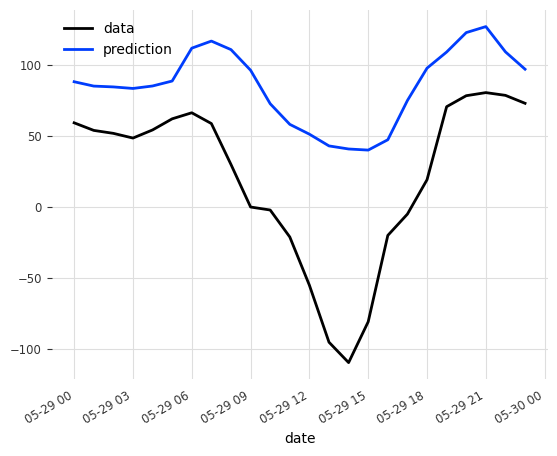

In [19]:
train = ts[-168:-24] # 1week
test = ts[-24:] # 1day

model_es = ExponentialSmoothing(seasonal_periods=24)
model_es.fit(train)

historical_fcast_es = model_es.historical_forecasts(
    train, forecast_horizon=24, verbose=True)
pred = model_es.predict(len(test))


test.plot(label="data")
pred.plot(label="prediction")
print("RMSE = {:.2f}%".format(rmse(pred, test)))

today = date.today()

# save excel file
df_predict = pred.pd_dataframe()
df_predict
df_predict.to_csv('1 week_price_{}.csv'.format(today))

### 1 month

  0%|          | 0/626 [00:00<?, ?it/s]

RMSE = 49.87%


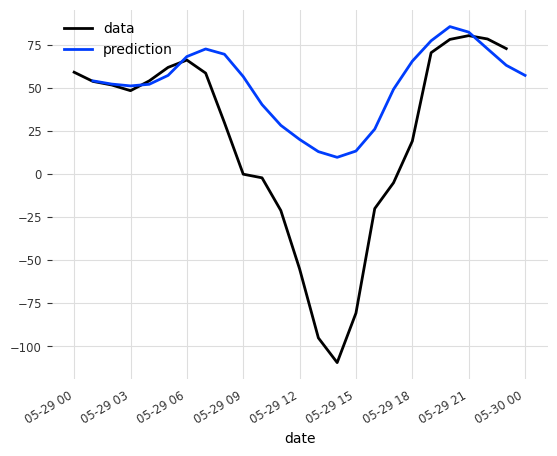

In [22]:
train_day = ts[-720:-23] # 30days
test = ts[-24:] # 1day

model_es = ExponentialSmoothing(seasonal_periods=24)
model_es.fit(train_day)

historical_fcast_es = model_es.historical_forecasts(
    train_day, forecast_horizon=24, retrain=True, verbose=True)
pred = model_es.predict(len(test))


test.plot(label="data")
pred.plot(label="prediction")
print("RMSE = {:.2f}%".format(rmse(pred, test)))

today = date.today()
df_predict = pred.pd_dataframe()
df_predict
df_predict.to_csv('1 month_price_{}.csv'.format(today))

In [ ]:
# Register the model in the MLflow registry
run_id_active = mlflow.active_run().info.run_id
model_uri = "runs:/" + run_id_active + "/elprice_predictor"
model_version = mlflow.register_model(model_uri, "model_es_pred")

mlflow.end_run()